<a href="https://colab.research.google.com/github/AishaEvering/PyTorch_Exercises/blob/main/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.91 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c33e7a73c70>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 46.8MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 16.964 seconds


### Make predictions on the entire test dataset with the model

In [11]:
from tqdm.auto import tqdm
from typing import List
import torch

def make_predictions(model: torch.nn.Module, dataLoader: torch.utils.data.dataloader.DataLoader, device: torch.device = device) -> List[torch.Tensor]:

  preds = []

  model.eval()

  with torch.inference_mode():
    for X, y in tqdm(dataLoader):

      # put data on device
      X, y = X.to(device), y.to(device)

      # make prediction

      # Pass the data through the model
      test_logits = model(X)

      # Convert the pred logits to pred probs
      pred_probs = torch.softmax(test_logits, dim=1)

      # Convert the pred probs into pred labels
      pred_labels = torch.argmax(pred_probs, dim=1)

      preds.append(pred_labels)

  return torch.cat(preds).cpu()


In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
test_preds = make_predictions(model=model_0,
                              dataLoader=test_dataloader,
                              device=device)
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [13]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.9 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [14]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


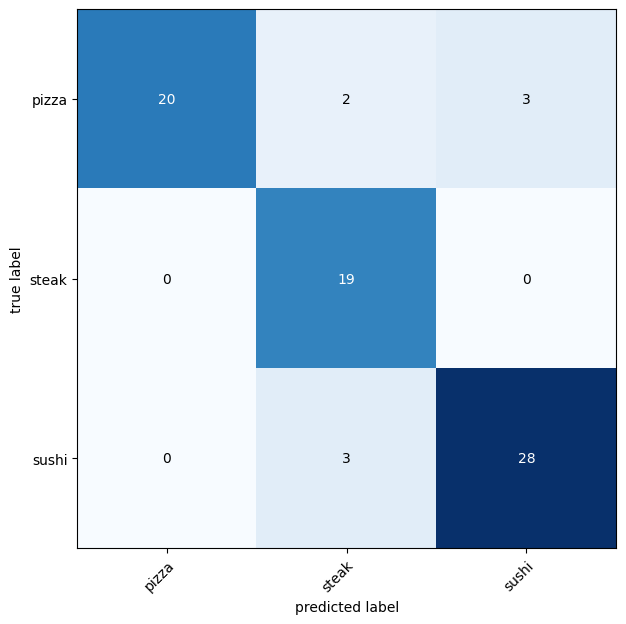

In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

ground_truth = torch.cat([y for X, y in test_dataloader])

conf_matrix = ConfusionMatrix(num_classes=len(class_names), task="multiclass")

conf_matrix_tensor = conf_matrix(preds=test_preds, target = ground_truth)

fig, ax = plot_confusion_matrix(conf_mat = conf_matrix_tensor.numpy(), class_names = class_names, figsize=(10, 7))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [16]:
from typing import List, Tuple, Dict
from PIL import Image

def predict(model: torch.nn.Module, path: str, img_size: Tuple[int, int] = (224, 224), device: torch.device = device) -> Tuple[int, str]:
  # create transform
  img_transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  ])

  # get image
  img = Image.open(path)

  # transform image
  transform_img = img_transform(img).unsqueeze(0)

  model.eval()

  with torch.inference_mode():
    pred_logit = model(transform_img.to(device))
    pred_prob = torch.softmax(pred_logit, dim = 1)
    pred_label = torch.argmax(pred_prob, dim = 1)
    pred_class = class_names[pred_label.cpu()]

  return pred_prob.unsqueeze(0).max().cpu().item(), pred_class



def predict_and_store(model: torch.nn.Module, test_paths: List[str], img_size: Tuple[int, int] = (224, 224),
                      device: torch.device = device) -> List[Dict]:
  predictions = []

  for path in tqdm(test_paths):
    prediction = {}

    prediction['path'] = path
    prediction['class_name'] = path.parent.stem

    # get prediction
    prob, label = predict(model=model, path=path, img_size=img_size, device = device)

    prediction['probability'] = prob
    prediction['label'] = label
    prediction['correct'] = path.parent.stem == label

    predictions.append(prediction)

  return predictions

In [17]:
from pathlib import Path
import pandas as pd

test_dir = Path(test_dir)
img_paths = list(test_dir.glob('*/*.jpg'))

preds_dict = predict_and_store(model=model_0, test_paths=img_paths)

df_preds = pd.DataFrame(preds_dict)
df_preds.head()

  0%|          | 0/75 [00:00<?, ?it/s]

,path,class_name,probability,label,correct
0,data/pizza_steak_sushi/test/pizza/2236338.jpg,pizza,0.408769,pizza,True
1,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.444701,sushi,False
2,data/pizza_steak_sushi/test/pizza/1925494.jpg,pizza,0.786989,pizza,True
3,data/pizza_steak_sushi/test/pizza/3475871.jpg,pizza,0.450376,pizza,True
4,data/pizza_steak_sushi/test/pizza/2019408.jpg,pizza,0.589452,pizza,True


In [18]:
# get top wrong
top_wrong_pred = df_preds.sort_values(by=['correct', 'probability'], ascending=[True, False])
top_wrong_pred = top_wrong_pred.head()
top_wrong_pred

,path,class_name,probability,label,correct
42,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.546966,steak,False
50,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.449595,steak,False
1,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.444701,sushi,False
21,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.435138,sushi,False
9,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,0.426874,sushi,False


In [19]:
from typing import Tuple

def visualize_preds(data: pd.DataFrame, row_count: int = 2, col_count: int=3, figSize: Tuple[int, int] = (10, 6)) -> None:
  fig, ax = plt.subplots(row_count, col_count, figsize = figSize)

  for i, ax in enumerate(ax.flat):
    if i < len(data):
      pth = data.iloc[i]['path']
      ax.imshow(Image.open(pth))
      ax.set_title(f"True: {data.iloc[i]['class_name']} | Pred: {data.iloc[i]['label']}\nProb: {(data.iloc[i]['probability'] * 100):.2f}%")
      ax.axis(False)
    else:
      ax.axis(False)

  plt.tight_layout()
  plt.show()

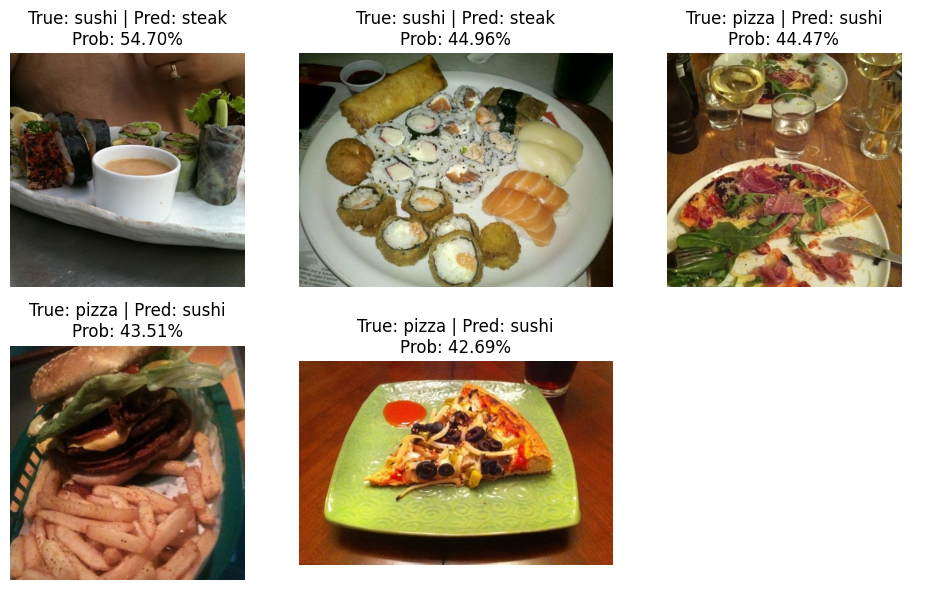

In [20]:
visualize_preds(top_wrong_pred)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [21]:
import requests
import os

def download_custom_img(github_path: str, path: str, name: str) -> None:

  custom_images_root = "data/custom_images"
  full_path = os.path.join(custom_images_root, path)

  if os.path.isdir(full_path):
      print(f"{full_path} directory exists, skipping re-download.")
  else:
      print(f"Did not find {full_path}, creating it...")
      os.makedirs(full_path, exist_ok=True)

  custom_image_path = os.path.join(full_path, name)

  if not os.path.isfile(custom_image_path):
    with open(custom_image_path, "wb") as f:
      request = requests.get(github_path)
      print(f"Downloading {custom_image_path}...")
      f.write(request.content)
  else:
      print(f"{custom_image_path} already exists, skipping download...")

In [22]:
download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/saundarya-srinivasan-60nzTP7_hMQ-unsplash.jpg",
    path="pizza", name="custom_pizza.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/shayan-ramesht-exSEmuA7R7k-unsplash.jpg",
    path="pizza", name="custom_pizza_2.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/charlesdeluvio-3bhnI1Am5Yc-unsplash.jpg",
    path="ice_cream", name="ice_cream.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/allec-gomes-QzX4rrfkUWo-unsplash.jpg",
    path="flower", name="flower.jpeg")


Did not find data/custom_images/pizza, creating it...
data/custom_images/pizza directory exists, skipping re-download.
Did not find data/custom_images/ice_cream, creating it...
Did not find data/custom_images/flower, creating it...


In [23]:
data_path = Path('data')
custom_img_path = data_path / "custom_images"

custom_paths = [
    custom_img_path / 'pizza/custom_pizza.jpeg',
    custom_img_path / 'pizza/custom_pizza_2.jpeg',
    custom_img_path / 'flower/flower.jpeg',
    custom_img_path / 'ice_cream/ice_cream.jpeg',
]

preds_dict = predict_and_store(model=model_0, test_paths=custom_paths)

df_custom_img_preds = pd.DataFrame(preds_dict)

df_custom_img_preds.head()


  0%|          | 0/4 [00:00<?, ?it/s]

,path,class_name,probability,label,correct
0,data/custom_images/pizza/custom_pizza.jpeg,pizza,0.403874,pizza,True
1,data/custom_images/pizza/custom_pizza_2.jpeg,pizza,0.430423,steak,False
2,data/custom_images/flower/flower.jpeg,flower,0.649266,sushi,False
3,data/custom_images/ice_cream/ice_cream.jpeg,ice_cream,0.479079,sushi,False


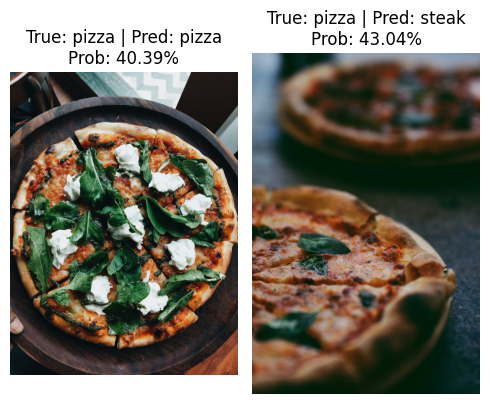

In [24]:
# Get an image of pizza/steak/sushi
custom_food_imgs = df_custom_img_preds[df_custom_img_preds['class_name'] == 'pizza']

visualize_preds(data = custom_food_imgs, row_count = 1, col_count = 2, figSize = (5, 5))

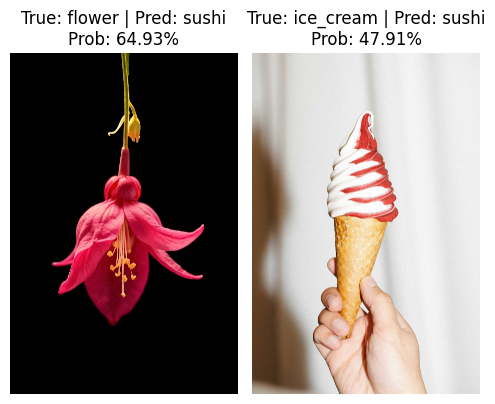

In [25]:
# Get an image of not pizza/steak/sushi
custom_other_imgs = df_custom_img_preds[(df_custom_img_preds['class_name'] == 'flower') | (df_custom_img_preds['class_name'] == 'ice_cream')]

visualize_preds(data = custom_other_imgs, row_count = 1, col_count = 2, figSize = (5, 5))

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [26]:
# Recreate a new model
import torch
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model_1.features.parameters():
  param.requires_grad = False

In [27]:
model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [28]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device)
)

model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [29]:
summary(model=model_1,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [30]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

# Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0010)

start_time = timer()

results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()

print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0353 | train_acc: 0.4961 | test_loss: 0.8766 | test_acc: 0.7841
Epoch: 2 | train_loss: 0.9482 | train_acc: 0.5039 | test_loss: 0.8536 | test_acc: 0.5691
Epoch: 3 | train_loss: 0.7814 | train_acc: 0.6758 | test_loss: 0.7438 | test_acc: 0.7850
Epoch: 4 | train_loss: 0.7164 | train_acc: 0.7695 | test_loss: 0.6542 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.6955 | train_acc: 0.7617 | test_loss: 0.5659 | test_acc: 0.8854
Epoch: 6 | train_loss: 0.5959 | train_acc: 0.7852 | test_loss: 0.5527 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.5891 | train_acc: 0.8047 | test_loss: 0.5802 | test_acc: 0.8466
Epoch: 8 | train_loss: 0.5033 | train_acc: 0.8164 | test_loss: 0.5840 | test_acc: 0.8163
Epoch: 9 | train_loss: 0.5593 | train_acc: 0.7812 | test_loss: 0.5326 | test_acc: 0.8362
Epoch: 10 | train_loss: 0.4911 | train_acc: 0.8008 | test_loss: 0.4863 | test_acc: 0.8873
[INFO] Total training time: 17.520 seconds


In [31]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


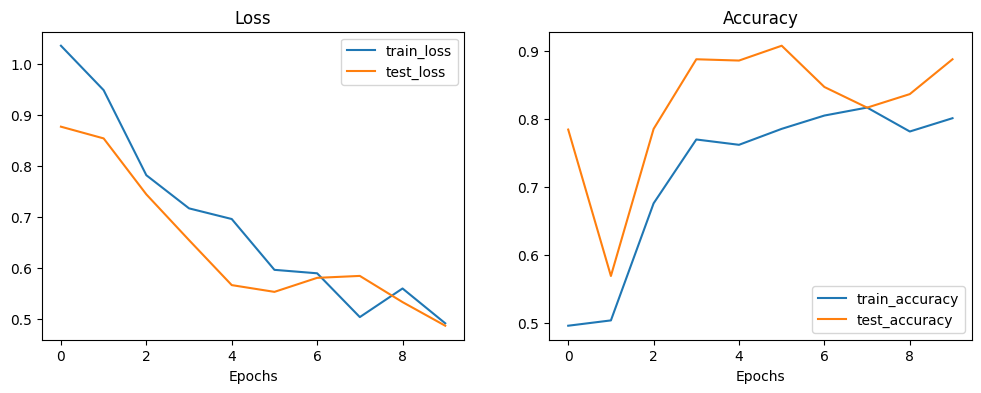

In [32]:
plot_loss_curves(results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [33]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [34]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [35]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3345d27880>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [36]:
# Recreate a new model
import torch
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model_2.features.parameters():
  param.requires_grad = False

model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device)
)

summary(model=model_2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Train a model with 20% of the data

In [37]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

# Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0010)

start_time = timer()

results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()

print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9363 | train_acc: 0.6146 | test_loss: 0.6857 | test_acc: 0.7602
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8167 | test_loss: 0.5215 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.5562 | train_acc: 0.8542 | test_loss: 0.4654 | test_acc: 0.9068
Epoch: 4 | train_loss: 0.4454 | train_acc: 0.9021 | test_loss: 0.4052 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4111 | train_acc: 0.9000 | test_loss: 0.3591 | test_acc: 0.9347
Epoch: 6 | train_loss: 0.4233 | train_acc: 0.8792 | test_loss: 0.3332 | test_acc: 0.9284
Epoch: 7 | train_loss: 0.3976 | train_acc: 0.8875 | test_loss: 0.3289 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.3151 | train_acc: 0.9167 | test_loss: 0.3015 | test_acc: 0.9256
Epoch: 9 | train_loss: 0.3051 | train_acc: 0.9250 | test_loss: 0.2871 | test_acc: 0.9222
Epoch: 10 | train_loss: 0.3572 | train_acc: 0.8708 | test_loss: 0.2902 | test_acc: 0.9131
[INFO] Total training time: 32.933 seconds


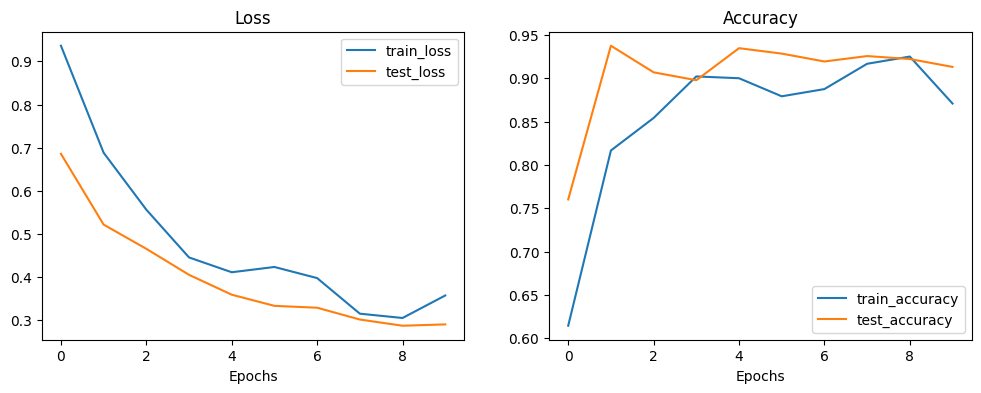

In [38]:
plot_loss_curves(results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [56]:
# Create a transform to transform the data
from torchvision import transforms, models

effnet_b1_transform = transforms.Compose([transforms.Resize((256, 256)),
                                          transforms.CenterCrop((240,240)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
])

In [57]:
# Import the data
train_dataloader_effnet_b1, test_dataloader_effnet_b1, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b1_transform,
                                                                                                   batch_size=32)

In [58]:
# Recreate a new model
import torch
import torchvision

weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b1(weights=weights).to(device)

for param in model_3.features.parameters():
  param.requires_grad = False

In [59]:
model_3.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [60]:
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device)
)

In [61]:
summary(model=model_3,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [62]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

# Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0010)

start_time = timer()

model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b1,
                              test_dataloader=test_dataloader_effnet_b1,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=10,
                              device=device)

end_time = timer()

print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0917 | train_acc: 0.4648 | test_loss: 0.9929 | test_acc: 0.6913
Epoch: 2 | train_loss: 0.9246 | train_acc: 0.8867 | test_loss: 0.9133 | test_acc: 0.8646
Epoch: 3 | train_loss: 0.8919 | train_acc: 0.7578 | test_loss: 0.8468 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.7838 | train_acc: 0.8867 | test_loss: 0.7938 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.8555 | train_acc: 0.7891 | test_loss: 0.7441 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.7417 | train_acc: 0.7969 | test_loss: 0.7130 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.6283 | train_acc: 0.9414 | test_loss: 0.6629 | test_acc: 0.9271
Epoch: 8 | train_loss: 0.5802 | train_acc: 0.9453 | test_loss: 0.6327 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.6442 | train_acc: 0.8125 | test_loss: 0.6057 | test_acc: 0.9271
Epoch: 10 | train_loss: 0.6111 | train_acc: 0.7969 | test_loss: 0.5920 | test_acc: 0.9062
[INFO] Total training time: 21.032 seconds


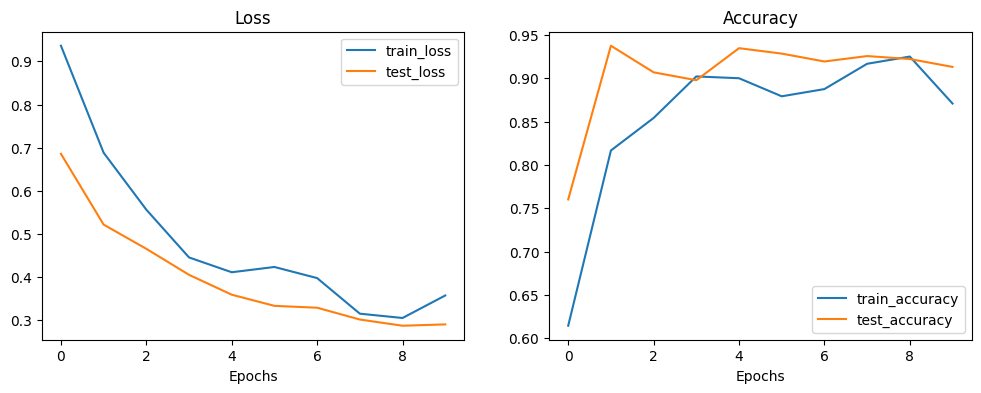

In [63]:
plot_loss_curves(results)